In [1]:
using Plots; gr();
using DelimitedFiles
using Statistics
using StatsBase
using StatGeochem # for nanmean 

In [2]:
res_path = "../data/base_single/base_large/"

"../data/base_single/base_large/"

In [3]:
###### Parse crust types into dict from key to name 

crust_types = Dict{String, String}()
f = open("../resources/CNtype1_key.txt", "r")
for (i, l) in enumerate(readlines(f))
    if ((i-1) % 5 == 0) & (i != 1)
        spl = findfirst(" ", l)
        crust_types[l[1:spl[1]-1]] = l[spl[1]+1:end]
    end
end

In [4]:
for k in keys(crust_types)
    println("(\"$k\", \"$(crust_types[k])\"),")
end

("L1", " 12: continental arc"),
("C-", " 29: continental shelf"),
("Y3", " 36: Caspian Sea oceanic"),
("B-", " 28: melt affected o.c. and oceanic plateaus"),
("Q-", " 18: orogen, thick upper crust, fast middle crust"),
("D-", " 01: Platform "),
("V1", " 31: inactive ridge, Alpha Ridge"),
("L2", " 13: slow continental arc"),
("I2", " 09: slow late Proter.  "),
("T-", " 21: Margin-continent/shield  transition"),
("V2", " 32: thinned cont. crust, Red Sea"),
("X-", " 23: Rift"),
("Z2", " 25: fast Phanerozoic (E. Australia, S. Africa, N. Siberia)"),
("G2", " 05: late Archean "),
("E-", " 02: slow thin Platform "),
("J-", " 10: island arc"),
("W-", " 33: oceanic plateau with cont. crust"),
("I1", " 08: late Proter."),
("G1", " 04: early Archean "),
("Y2", " 35: intermed. cont./oc. crust, Black Sea"),
("R1", " 19: orogen with slow lower crust (Andes)"),
("U-", " 22: slow Margin/Shield (Antarctica)"),
("K-", " 11: forearc"),
("Y1", " 34: Caspian depression"),
("M-", " 14: extended crust"),
("N

In [5]:
cmap = Dict([("L1", "Arc"),
("C-", "Continental Margin"),
("Y3", "Extended"),
("B-", "Continental Margin"),
("Q-", "Orogenic"),
("D-", "Platform"),
("V1", "Orogenic"),
("L2", "Arc"),
("I2", "Proterozoic"),
("T-", "Continental Margin"),
("V2", "Extended"),
("X-", "Rifted"),
("Z2", "Phanerozoic"),
("G2", "Archean"),
("E-", "Platform"),
("J-", "Arc"),
("W-", "Continental Margin"),
("I1", "Proterozoic"),
("G1", "Archean"),
("Y2", "Continental Margin"),
("R1", "Andean"),
("U-", "Continental Margin"),
("K-", "Arc"),
("Y1", "Extended"),
("M-", "Extended"),
("N-", "Extended"),
("H1", "Proterozoic"),
("F-", "Archean"),
("O-", "Orogenic"),
("A1", "Continental Margin"),
("A0", "Continental Margin"),
("P-", "Orogenic"),
("R2", "Himalayan"),
("Z1", "Phanerozoic"),
("S-", "Continental Margin"),
("H2", "Proterozoic")])

Dict{String, String} with 36 entries:
  "L1" => "Arc"
  "C-" => "Continental Margin"
  "Y3" => "Extended"
  "B-" => "Continental Margin"
  "Q-" => "Orogenic"
  "D-" => "Platform"
  "V1" => "Orogenic"
  "L2" => "Arc"
  "I2" => "Proterozoic"
  "T-" => "Continental Margin"
  "V2" => "Extended"
  "X-" => "Rifted"
  "Z2" => "Phanerozoic"
  "G2" => "Archean"
  "E-" => "Platform"
  "J-" => "Arc"
  "W-" => "Continental Margin"
  "I1" => "Proterozoic"
  "G1" => "Archean"
  "Y2" => "Continental Margin"
  "R1" => "Andean"
  "U-" => "Continental Margin"
  "K-" => "Arc"
  "Y1" => "Extended"
  "M-" => "Extended"
  ⋮    => ⋮

In [6]:
####### Read crust types into array 

crust_array = readdlm("../resources/CNtype1-1.txt"); 
size(crust_array)

(180, 360)

In [12]:
function get_means(file, unique_cats=[])
    dat, h = readdlm(file, ',', header=true)
    lat_i = findfirst(isequal("sample_lat"), h[:])
    long_i = findfirst(isequal("sample_long"), h[:])

    # Find cats 
    cats = fill("", size(dat,1));
    for i in 1:size(dat,1)
        lat = dat[i,lat_i]
        lon = dat[i, long_i]

        # Index conversion from Brenhin's StatGeochem code for Crust1.0
        # Avoid edge cases at lat = -90.0, lon = 180.0
        ilon = mod(lon + 180, 360) - 180
        ilat = max(lat, -90+1e-9)

        # Convert lat and lon to index
        ilat = 91 - ceil(Int,ilat)
        ilon = 181 + floor(Int,ilon)

        cats[i] = crust_array[ilat, ilon]
    end
    cats = [cmap[c] for c in cats];
    
    # If unique cats was passed in, use it to preserve order between layers, else find unique_cats
    if length(unique_cats) == 0
        unique_cats = unique(cats)
    end
    num_cats = [sum(cats .== c) for c in unique_cats]

    #bar(1:length(num_cats), num_cats, xticks=(1:length(num_cats), unique_cats), xrotation=45, legend=false)
    
    means = zeros((length(unique_cats), 10))
    stds = zeros((length(unique_cats), 10))

    si_i = findfirst(isequal("SiO2"), h[:])
    h2_i = findfirst(isequal("CO2"), h[:])

    for (i, cat) in enumerate(unique_cats)
        means[i,:] .= nanmean(dat[cats .== cat, si_i:h2_i], dims=1)[:]
        stds[i,:] .= nanstd(dat[cats .== cat, si_i:h2_i], dims=1)[:]
    end 
    
    return cats, unique_cats, means, stds, num_cats
end

get_means (generic function with 2 methods)

In [13]:
m_cats, unique_cats, m_means, m_stds, num_cats = get_means("$res_path/results-middle.csv")
u_cats, _, u_means, u_stds, _ = get_means("$res_path/results-upper.csv", unique_cats)
l_cats, _, l_means, l_stds, _ = get_means("$res_path/results-lower.csv", unique_cats)
#dat, h = readdlm("$res_path/results-upper.csv", ',', header=true)

(["Proterozoic", "Archean", "Orogenic", "Proterozoic", "Proterozoic", "Proterozoic", "Archean", "Platform", "Proterozoic", "Arc"  …  "Himalayan", "Orogenic", "Proterozoic", "Orogenic", "Extended", "Proterozoic", "Proterozoic", "Orogenic", "Extended", "Archean"], ["Proterozoic", "Archean", "Platform", "Andean", "Himalayan", "Orogenic", "Rifted", "Arc", "Phanerozoic", "Extended", "Continental Margin"], [52.81395181060844 1.1143627786122683 … 1.1721188419033366 0.6708341494960725; 54.14220167024233 1.0819172648038693 … 1.2006697418246683 0.6930750523928495; … ; 53.279819350477084 1.0304432545935152 … 1.0466832671961919 0.712940843151576; 52.5540844610754 1.0817681071337817 … 0.9713467503335023 0.663795057410114], [4.609967795783709 0.7516078544406651 … 1.0896977582738858 0.8883909275784233; 5.317383784762147 0.7160177663199202 … 1.1120560222158982 0.9141005200519616; … ; 5.236710803422518 0.7390142764046828 … 1.2331035435015842 0.9178180379692933; 4.742877940697604 0.7756357152120392 … 1.

In [16]:
sum_to_one = 0.0
for i in 1:length(unique_cats)
    sum_to_one += num_cats[i]/length(m_cats)
    ms = join(round.(u_means[i,:], digits=2), " & ")
    println("$(unique_cats[i]) & $(round(num_cats[i]/length(m_cats), digits=2)) & Upper & Mean & $ms ", " \\\\")
    
    er = join(round.(u_stds[i,:], digits=2), " & ")
    println("& &  & Std & $er", " \\\\")
    
    ms = join(round.(m_means[i,:], digits=2), " & ")
    println(" &  & Middle && $ms ", " \\\\")
    
    er = join(round.(m_stds[i,:], digits=2), " & ")
    println("& &  & & $er", " \\\\")
    
    ms = join(round.(l_means[i,:], digits=2), " & ")
    println(" &  & Lower && $ms ", " \\\\")
    
    er = join(round.(l_stds[i,:], digits=2), " & ")
    println("& &  & & $er", " \\\\")
    
    println("\\hline")
    
end

Proterozoic & 0.38 & Upper & Mean & 59.18 & 0.92 & 17.37 & 6.67 & 2.91 & 5.51 & 4.14 & 3.19 & 0.06 & 0.06  \\
& &  & Std & 5.7 & 0.6 & 3.0 & 2.95 & 2.08 & 3.11 & 1.45 & 2.29 & 0.24 & 0.15 \\
 &  & Middle && 56.96 & 1.03 & 16.05 & 7.57 & 4.84 & 6.97 & 3.52 & 1.89 & 0.75 & 0.42  \\
& &  & & 6.9 & 0.7 & 2.68 & 3.17 & 3.41 & 3.39 & 1.32 & 1.9 & 0.87 & 0.71 \\
 &  & Lower && 52.81 & 1.11 & 15.41 & 8.7 & 7.46 & 8.63 & 3.0 & 1.02 & 1.17 & 0.67  \\
& &  & & 4.61 & 0.75 & 3.7 & 3.02 & 5.08 & 2.81 & 1.31 & 1.33 & 1.09 & 0.89 \\
\hline
Archean & 0.15 & Upper & Mean & 57.93 & 1.04 & 17.05 & 7.42 & 3.61 & 6.21 & 3.91 & 2.7 & 0.07 & 0.06  \\
& &  & Std & 5.79 & 0.65 & 2.76 & 3.03 & 2.34 & 3.08 & 1.35 & 2.11 & 0.26 & 0.16 \\
 &  & Middle && 56.81 & 1.04 & 15.95 & 7.72 & 4.9 & 7.01 & 3.48 & 1.87 & 0.82 & 0.41  \\
& &  & & 7.06 & 0.72 & 2.66 & 3.25 & 3.42 & 3.41 & 1.31 & 1.9 & 0.89 & 0.69 \\
 &  & Lower && 54.14 & 1.08 & 15.67 & 8.12 & 6.59 & 7.98 & 3.26 & 1.27 & 1.2 & 0.69  \\
& &  & & 5.32 & 0.72 & 3

In [10]:
println(sum_to_one)

0.0


In [37]:
r = rand(10)
println(std(r))

all = zeros(4)
for i in 0:3
    all[i+1]=std(repeat(r, 10^i))
end

0.30920936551941797


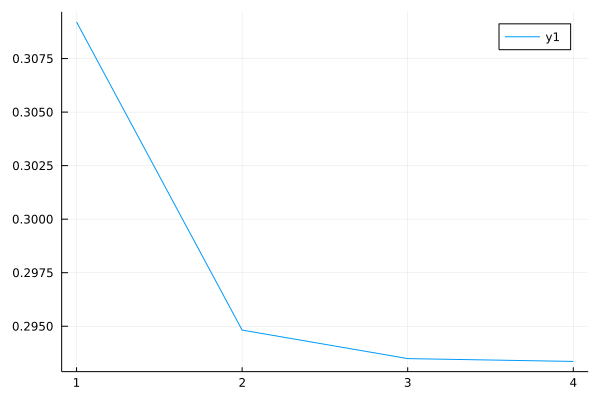

In [38]:
plot(all)